# Batch Operations Performance Analysis with Neon CRM SDK

This notebook demonstrates performance optimization techniques for batch operations using the Neon CRM SDK.

⚠️ **SAFETY NOTE**: This notebook contains only read-only operations for safety.
Database-modifying operations are commented out to prevent accidental changes.

In [11]:
import os
import time
import asyncio
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Dict, Any
import pandas as pd
import numpy as np
from neon_crm import NeonClient, types
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the client
client = NeonClient(
    org_id=os.getenv('NEON_ORG_ID'),
    api_key=os.getenv('NEON_API_KEY'),
)

print(f"Connected to Neon CRM - Environment: {client.environment}")
print(f"Timestamp: {datetime.now()}")

Connected to Neon CRM - Environment: production
Timestamp: 2025-09-20 22:41:17.833426


## 1. Performance Measurement Utilities

Helper functions to measure and analyze performance.

In [13]:
class PerformanceMonitor:
    """Monitor and analyze performance of batch operations."""
    
    def __init__(self):
        self.measurements = []
    
    def time_operation(self, operation_name: str, func, *args, **kwargs):
        """Time an operation and record the results."""
        start_time = time.time()
        
        try:
            result = func(*args, **kwargs)
            success = True
            error = None
        except Exception as e:
            result = None
            success = False
            error = str(e)
        
        end_time = time.time()
        duration = end_time - start_time
        
        measurement = {
            'operation': operation_name,
            'start_time': start_time,
            'end_time': end_time,
            'duration': duration,
            'success': success,
            'error': error,
            'timestamp': datetime.now()
        }
        
        self.measurements.append(measurement)
        
        if success:
            print(f"✓ {operation_name}: {duration:.2f}s")
        else:
            print(f"❌ {operation_name}: Failed after {duration:.2f}s - {error}")
        
        return result, measurement
    
    def get_summary(self) -> pd.DataFrame:
        """Get performance summary as DataFrame."""
        if not self.measurements:
            return pd.DataFrame()
        
        df = pd.DataFrame(self.measurements)
        return df
    
    def analyze_performance(self) -> Dict[str, Any]:
        """Analyze performance metrics."""
        df = self.get_summary()
        
        if df.empty:
            return {}
        
        # Filter successful operations for analysis
        successful_ops = df[df['success'] == True]
        
        if successful_ops.empty:
            return {'total_operations': len(df), 'successful_operations': 0}
        
        analysis = {
            'total_operations': len(df),
            'successful_operations': len(successful_ops),
            'success_rate': len(successful_ops) / len(df) * 100,
            'avg_duration': successful_ops['duration'].mean(),
            'min_duration': successful_ops['duration'].min(),
            'max_duration': successful_ops['duration'].max(),
            'total_time': successful_ops['duration'].sum(),
            'operations_per_second': len(successful_ops) / successful_ops['duration'].sum()
        }
        
        return analysis

# Initialize performance monitor
perf_monitor = PerformanceMonitor()
print("📊 Performance monitoring initialized")

📊 Performance monitoring initialized


## 2. Single vs Batch Request Performance

Compare performance of individual requests vs batch operations.

In [17]:
# Test single request performance
print("🔍 Testing single request performance...")

# Get some accounts for testing
accounts_result, measurement = perf_monitor.time_operation(
    "List Accounts (Single Request)",
    lambda: list(client.accounts.list(page_size=100, limit=50, user_type=types.UserType.INDIVIDUAL))
)

if accounts_result:
    print(f"Retrieved {len(accounts_result)} accounts")
    
    # Test individual account retrievals
    print("\n🔍 Testing individual account retrievals...")
    
    sample_accounts = accounts_result[:5]  # Test with first 5 accounts
    
    for i, account in enumerate(sample_accounts, 1):
        account_id = account.get('accountId')
        
        if account_id:
            account_detail, _ = perf_monitor.time_operation(
                f"Get Account {i} (ID: {account_id})",
                client.accounts.get,
                account_id
            )
        else:
            print(f"⚠️ Account {i}: No account ID found")
else:
    print("❌ Could not retrieve accounts for testing")

🔍 Testing single request performance...
✓ List Accounts (Single Request): 0.52s
Retrieved 50 accounts

🔍 Testing individual account retrievals...
✓ Get Account 1 (ID: 5602): 0.15s
✓ Get Account 2 (ID: 3133): 0.10s
✓ Get Account 3 (ID: 2228): 0.14s
✓ Get Account 4 (ID: 5093): 0.10s
✓ Get Account 5 (ID: 4781): 0.13s


## 3. Pagination Strategy Performance

Test different pagination strategies to find optimal page sizes.

In [19]:
# Test different page sizes for optimal performance
print("📄 Testing pagination strategy performance...")

page_sizes = [25, 50, 100, 200]
pagination_results = []

for page_size in page_sizes:
    print(f"\n🔍 Testing page size: {page_size}")
    
    # Test accounts list with different page sizes
    accounts_result, measurement = perf_monitor.time_operation(
        f"List Accounts (page_size={page_size})",
        lambda ps=page_size: list(client.accounts.list(page_size=ps, limit=100, user_type=types.UserType.INDIVIDUAL))
    )
    
    if accounts_result:
        records_per_second = len(accounts_result) / measurement['duration']
        pagination_results.append({
            'page_size': page_size,
            'total_records': len(accounts_result),
            'duration': measurement['duration'],
            'records_per_second': records_per_second,
            'success': True
        })
        print(f"  ✓ Retrieved {len(accounts_result)} records at {records_per_second:.1f} records/second")
    else:
        pagination_results.append({
            'page_size': page_size,
            'total_records': 0,
            'duration': measurement['duration'],
            'records_per_second': 0,
            'success': False
        })

# Analyze pagination performance
if pagination_results:
    pagination_df = pd.DataFrame(pagination_results)
    successful_pagination = pagination_df[pagination_df['success'] == True]
    
    if not successful_pagination.empty:
        print("\n📊 Pagination Performance Summary:")
        print(successful_pagination[['page_size', 'total_records', 'duration', 'records_per_second']].to_string(index=False))
        
        # Find optimal page size
        optimal_page_size = successful_pagination.loc[successful_pagination['records_per_second'].idxmax()]
        print(f"\n🎯 Optimal page size: {optimal_page_size['page_size']} ({optimal_page_size['records_per_second']:.1f} records/second)")
    else:
        print("❌ No successful pagination tests")
else:
    print("❌ No pagination results to analyze")

📄 Testing pagination strategy performance...

🔍 Testing page size: 25
✓ List Accounts (page_size=25): 0.64s
  ✓ Retrieved 100 records at 156.2 records/second

🔍 Testing page size: 50
✓ List Accounts (page_size=50): 0.22s
  ✓ Retrieved 100 records at 450.9 records/second

🔍 Testing page size: 100
✓ List Accounts (page_size=100): 0.16s
  ✓ Retrieved 100 records at 643.4 records/second

🔍 Testing page size: 200
✓ List Accounts (page_size=200): 0.08s
  ✓ Retrieved 100 records at 1301.1 records/second

📊 Pagination Performance Summary:
 page_size  total_records  duration  records_per_second
        25            100  0.640097          156.226287
        50            100  0.221756          450.946123
       100            100  0.155418          643.425463
       200            100  0.076857         1301.116137

🎯 Optimal page size: 200 (1301.1 records/second)


## 4. Search Operation Performance

Analyze performance of search operations with different criteria.

In [22]:
# Test search operation performance
print("🔍 Testing search operation performance...")

# Test different search strategies
search_tests = [
    {
        'name': 'Simple Account Search',
        'resource': 'accounts',
        'request': {
            'searchFields': [
                {'field': 'Account Type', 'operator': 'EQUAL', 'value': 'Individual'}
            ],
            'outputFields': ['Account ID', 'First Name', 'Last Name', 'Email 1'],
            'pagination': {'currentPage': 0, 'pageSize': 200}
        }
    },
    {
        'name': 'Donation Search by Date Range',
        'resource': 'donations',
        'request': {
            'searchFields': [
                {'field': 'Donation Date', 'operator': 'GREATER_THAN', 'value': '2023-01-01'}
            ],
            'outputFields': ['Donation ID', 'Account ID', 'Donation Amount', 'Donation Date'],
            'pagination': {'currentPage': 0, 'pageSize': 200}
        }
    }
]

search_results = []

for test in search_tests:
    print(f"\n🔍 {test['name']}...")
    
    try:
        if test['resource'] == 'accounts':
            search_result, measurement = perf_monitor.time_operation(
                test['name'],
                lambda: list(client.accounts.search(test['request'], validate=False))
            )
        elif test['resource'] == 'donations':
            search_result, measurement = perf_monitor.time_operation(
                test['name'],
                lambda: list(client.donations.search(test['request'], validate=False))
            )
        
        if search_result:
            records_per_second = len(search_result) / measurement['duration']
            search_results.append({
                'test_name': test['name'],
                'resource': test['resource'],
                'total_records': len(search_result),
                'duration': measurement['duration'],
                'records_per_second': records_per_second,
                'success': True
            })
            print(f"  ✓ Found {len(search_result)} records at {records_per_second:.1f} records/second")
        else:
            search_results.append({
                'test_name': test['name'],
                'resource': test['resource'],
                'total_records': 0,
                'duration': measurement['duration'],
                'records_per_second': 0,
                'success': False
            })
            
    except Exception as e:
        print(f"  ❌ {test['name']} failed: {e}")
        search_results.append({
            'test_name': test['name'],
            'resource': test['resource'],
            'total_records': 0,
            'duration': 0,
            'records_per_second': 0,
            'success': False
        })

# Display search performance results
if search_results:
    search_df = pd.DataFrame(search_results)
    successful_searches = search_df[search_df['success'] == True]
    
    if not successful_searches.empty:
        print("\n📊 Search Performance Summary:")
        print(successful_searches[['test_name', 'total_records', 'duration', 'records_per_second']].to_string(index=False))
    else:
        print("❌ No successful search operations")
else:
    print("❌ No search results to analyze")

🔍 Testing search operation performance...

🔍 Simple Account Search...
✓ Simple Account Search: 12.92s
  ✓ Found 3690 records at 285.7 records/second

🔍 Donation Search by Date Range...
✓ Donation Search by Date Range: 10.16s
  ✓ Found 2614 records at 257.2 records/second

📊 Search Performance Summary:
                    test_name  total_records  duration  records_per_second
        Simple Account Search           3690 12.915984          285.692521
Donation Search by Date Range           2614 10.161600          257.242957


## 5. Concurrent Operations Performance

Test performance improvements from concurrent operations.

In [21]:
# Test concurrent operations
print("🔀 Testing concurrent operations performance...")

def perform_account_search(search_criteria):
    """Perform an account search operation."""
    try:
        request = {
            'searchFields': search_criteria,
            'outputFields': ['Account ID', 'First Name', 'Last Name'],
            'pagination': {'currentPage': 0, 'pageSize': 200}
        }
        result = list(client.accounts.search(request, validate=False))
        return len(result)
    except Exception as e:
        return 0

# Define multiple search criteria for concurrent testing
concurrent_searches = [
    [{'field': 'Account Type', 'operator': 'EQUAL', 'value': 'Individual'}],
    [{'field': 'Account Type', 'operator': 'EQUAL', 'value': 'Organization'}],
    [{'field': 'First Name', 'operator': 'NOT_BLANK', 'value': ''}],
    [{'field': 'Last Name', 'operator': 'NOT_BLANK', 'value': ''}],
]

# Sequential execution
print("\n📝 Sequential execution...")
sequential_results = []
sequential_start = time.time()

for i, criteria in enumerate(concurrent_searches, 1):
    result_count, measurement = perf_monitor.time_operation(
        f"Sequential Search {i}",
        perform_account_search,
        criteria
    )
    sequential_results.append(result_count)

sequential_total_time = time.time() - sequential_start
sequential_total_records = sum(sequential_results)

print(f"✓ Sequential: {sequential_total_records} total records in {sequential_total_time:.2f}s")

# Concurrent execution
print("\n🔀 Concurrent execution...")
concurrent_start = time.time()
concurrent_results = []

with ThreadPoolExecutor(max_workers=4) as executor:
    # Submit all searches concurrently
    future_to_criteria = {
        executor.submit(perform_account_search, criteria): criteria 
        for criteria in concurrent_searches
    }
    
    # Collect results as they complete
    for future in as_completed(future_to_criteria):
        try:
            result = future.result()
            concurrent_results.append(result)
        except Exception as e:
            print(f"❌ Concurrent search failed: {e}")
            concurrent_results.append(0)

concurrent_total_time = time.time() - concurrent_start
concurrent_total_records = sum(concurrent_results)

print(f"✓ Concurrent: {concurrent_total_records} total records in {concurrent_total_time:.2f}s")

# Compare performance
if sequential_total_time > 0 and concurrent_total_time > 0:
    speedup = sequential_total_time / concurrent_total_time
    efficiency = (speedup / len(concurrent_searches)) * 100
    
    print(f"\n📊 Concurrency Performance Analysis:")
    print(f"Sequential Time: {sequential_total_time:.2f}s")
    print(f"Concurrent Time: {concurrent_total_time:.2f}s")
    print(f"Speedup: {speedup:.2f}x")
    print(f"Efficiency: {efficiency:.1f}%")
    
    if speedup > 1.0:
        print(f"🎯 Concurrent operations are {speedup:.2f}x faster!")
    else:
        print(f"⚠️ Sequential operations performed better in this test")
else:
    print("❌ Could not compare performance - insufficient timing data")

🔀 Testing concurrent operations performance...

📝 Sequential execution...
✓ Sequential Search 1: 50.17s
✓ Sequential Search 2: 0.20s
✓ Sequential Search 3: 49.40s
✓ Sequential Search 4: 49.98s
✓ Sequential: 11128 total records in 149.76s

🔀 Concurrent execution...
✓ Concurrent: 11128 total records in 50.87s

📊 Concurrency Performance Analysis:
Sequential Time: 149.76s
Concurrent Time: 50.87s
Speedup: 2.94x
Efficiency: 73.6%
🎯 Concurrent operations are 2.94x faster!


## 6. Memory Usage Analysis

Monitor memory usage during batch operations.

In [24]:
import psutil
import gc

# Memory usage monitoring
print("💾 Memory usage analysis...")

def get_memory_usage():
    """Get current memory usage in MB."""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

# Test memory usage with different batch sizes
batch_sizes = [50, 100, 200, 500]
memory_results = []

for batch_size in batch_sizes:
    print(f"\n💾 Testing memory usage with batch size: {batch_size}")
    
    # Clear memory before test
    gc.collect()
    initial_memory = get_memory_usage()
    
    try:
        # Perform batch operation
        start_time = time.time()
        accounts = list(client.accounts.list(page_size=batch_size, limit=batch_size, user_type=types.UserType.INDIVIDUAL))
        duration = time.time() - start_time
        
        peak_memory = get_memory_usage()
        memory_used = peak_memory - initial_memory
        
        memory_results.append({
            'batch_size': batch_size,
            'records_retrieved': len(accounts),
            'initial_memory_mb': initial_memory,
            'peak_memory_mb': peak_memory,
            'memory_used_mb': memory_used,
            'memory_per_record_kb': (memory_used * 1024) / len(accounts) if len(accounts) > 0 else 0,
            'duration': duration,
            'success': True
        })
        
        print(f"  ✓ Retrieved {len(accounts)} records")
        print(f"  💾 Memory used: {memory_used:.1f} MB ({(memory_used * 1024) / len(accounts):.1f} KB per record)")
        
        # Clear memory after test
        del accounts
        gc.collect()
        
    except Exception as e:
        print(f"  ❌ Failed: {e}")
        memory_results.append({
            'batch_size': batch_size,
            'records_retrieved': 0,
            'initial_memory_mb': initial_memory,
            'peak_memory_mb': get_memory_usage(),
            'memory_used_mb': 0,
            'memory_per_record_kb': 0,
            'duration': 0,
            'success': False
        })

# Display memory analysis results
if memory_results:
    memory_df = pd.DataFrame(memory_results)
    successful_memory = memory_df[memory_df['success'] == True]
    
    if not successful_memory.empty:
        print("\n📊 Memory Usage Analysis:")
        display_cols = ['batch_size', 'records_retrieved', 'memory_used_mb', 'memory_per_record_kb', 'duration']
        print(successful_memory[display_cols].to_string(index=False))
        
        # Find most memory-efficient batch size
        if successful_memory['memory_per_record_kb'].sum() > 0:
            most_efficient = successful_memory.loc[successful_memory['memory_per_record_kb'].idxmin()]
            print(f"\n🎯 Most memory-efficient batch size: {most_efficient['batch_size']} ({most_efficient['memory_per_record_kb']:.1f} KB per record)")
    else:
        print("❌ No successful memory tests")
else:
    print("❌ No memory results to analyze")

💾 Memory usage analysis...

💾 Testing memory usage with batch size: 50
  ✓ Retrieved 50 records
  💾 Memory used: 3.4 MB (70.4 KB per record)

💾 Testing memory usage with batch size: 100
  ✓ Retrieved 100 records
  💾 Memory used: 0.2 MB (2.1 KB per record)

💾 Testing memory usage with batch size: 200
  ✓ Retrieved 200 records
  💾 Memory used: 0.5 MB (2.6 KB per record)

💾 Testing memory usage with batch size: 500
  ✓ Retrieved 500 records
  💾 Memory used: 1.0 MB (2.1 KB per record)

📊 Memory Usage Analysis:
 batch_size  records_retrieved  memory_used_mb  memory_per_record_kb  duration
         50                 50        3.437500                70.400  0.508991
        100                100        0.203125                 2.080  0.144163
        200                200        0.500000                 2.560  0.154034
        500                500        1.046875                 2.144  0.215402

🎯 Most memory-efficient batch size: 100 (2.1 KB per record)


## 7. Performance Visualization

Create visualizations of performance metrics.

📈 Creating performance visualizations...


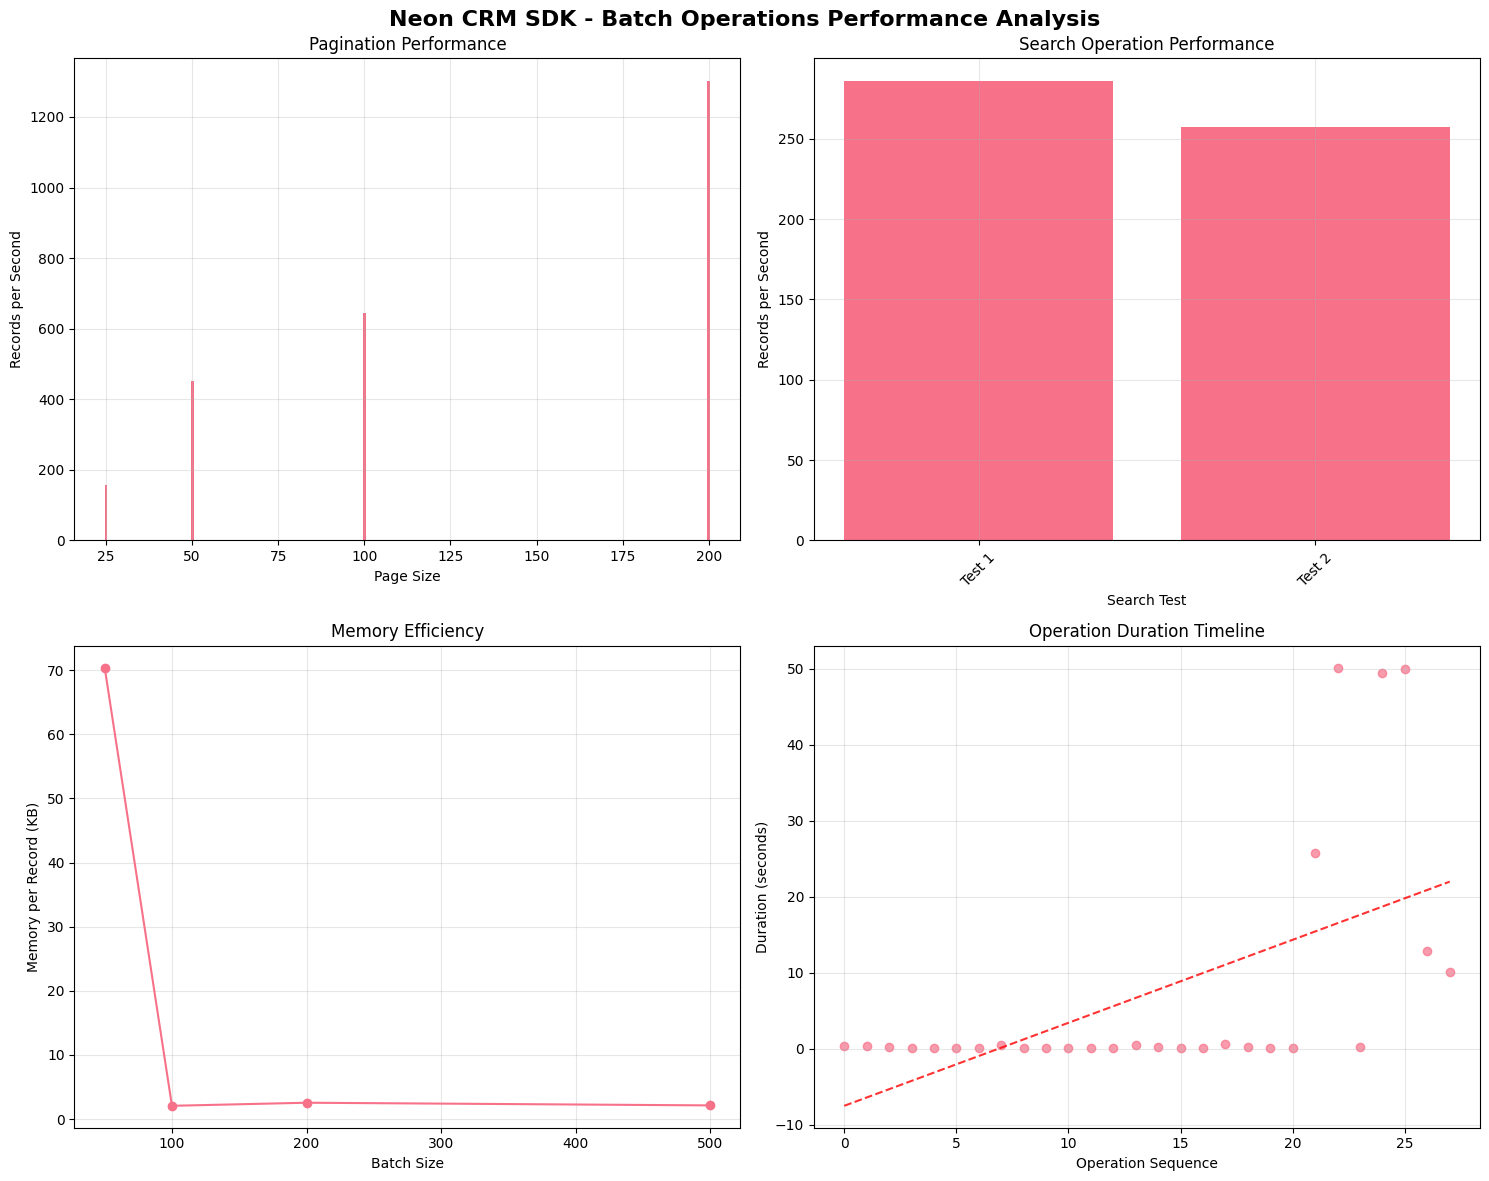

✓ Performance visualizations created


In [25]:
# Create performance visualizations
print("📈 Creating performance visualizations...")

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Neon CRM SDK - Batch Operations Performance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Pagination Performance
if 'pagination_df' in locals() and not pagination_df.empty:
    successful_pagination = pagination_df[pagination_df['success'] == True]
    if not successful_pagination.empty:
        axes[0, 0].bar(successful_pagination['page_size'], successful_pagination['records_per_second'])
        axes[0, 0].set_title('Pagination Performance')
        axes[0, 0].set_xlabel('Page Size')
        axes[0, 0].set_ylabel('Records per Second')
        axes[0, 0].grid(True, alpha=0.3)
    else:
        axes[0, 0].text(0.5, 0.5, 'No pagination data', ha='center', va='center', transform=axes[0, 0].transAxes)
else:
    axes[0, 0].text(0.5, 0.5, 'No pagination data', ha='center', va='center', transform=axes[0, 0].transAxes)

# Plot 2: Search Performance
if 'search_df' in locals() and not search_df.empty:
    successful_searches = search_df[search_df['success'] == True]
    if not successful_searches.empty:
        axes[0, 1].bar(range(len(successful_searches)), successful_searches['records_per_second'])
        axes[0, 1].set_title('Search Operation Performance')
        axes[0, 1].set_xlabel('Search Test')
        axes[0, 1].set_ylabel('Records per Second')
        axes[0, 1].set_xticks(range(len(successful_searches)))
        axes[0, 1].set_xticklabels([f"Test {i+1}" for i in range(len(successful_searches))], rotation=45)
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'No search data', ha='center', va='center', transform=axes[0, 1].transAxes)
else:
    axes[0, 1].text(0.5, 0.5, 'No search data', ha='center', va='center', transform=axes[0, 1].transAxes)

# Plot 3: Memory Usage
if 'memory_df' in locals() and not memory_df.empty:
    successful_memory = memory_df[memory_df['success'] == True]
    if not successful_memory.empty:
        axes[1, 0].plot(successful_memory['batch_size'], successful_memory['memory_per_record_kb'], 'o-')
        axes[1, 0].set_title('Memory Efficiency')
        axes[1, 0].set_xlabel('Batch Size')
        axes[1, 0].set_ylabel('Memory per Record (KB)')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'No memory data', ha='center', va='center', transform=axes[1, 0].transAxes)
else:
    axes[1, 0].text(0.5, 0.5, 'No memory data', ha='center', va='center', transform=axes[1, 0].transAxes)

# Plot 4: Overall Performance Timeline
perf_summary = perf_monitor.get_summary()
if not perf_summary.empty:
    successful_ops = perf_summary[perf_summary['success'] == True]
    if not successful_ops.empty:
        axes[1, 1].scatter(range(len(successful_ops)), successful_ops['duration'], alpha=0.7)
        axes[1, 1].set_title('Operation Duration Timeline')
        axes[1, 1].set_xlabel('Operation Sequence')
        axes[1, 1].set_ylabel('Duration (seconds)')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(range(len(successful_ops)), successful_ops['duration'], 1)
        p = np.poly1d(z)
        axes[1, 1].plot(range(len(successful_ops)), p(range(len(successful_ops))), "r--", alpha=0.8)
    else:
        axes[1, 1].text(0.5, 0.5, 'No timing data', ha='center', va='center', transform=axes[1, 1].transAxes)
else:
    axes[1, 1].text(0.5, 0.5, 'No timing data', ha='center', va='center', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

print("✓ Performance visualizations created")

## 8. Performance Recommendations

Generate performance optimization recommendations based on test results.

In [26]:
# Generate performance recommendations
print("🎯 Generating performance optimization recommendations...")

recommendations = []

# Analyze overall performance
overall_analysis = perf_monitor.analyze_performance()

if overall_analysis:
    print(f"\n📊 Overall Performance Summary:")
    print(f"Total Operations: {overall_analysis.get('total_operations', 0)}")
    print(f"Successful Operations: {overall_analysis.get('successful_operations', 0)}")
    print(f"Success Rate: {overall_analysis.get('success_rate', 0):.1f}%")
    print(f"Average Duration: {overall_analysis.get('avg_duration', 0):.2f}s")
    print(f"Operations per Second: {overall_analysis.get('operations_per_second', 0):.2f}")
    
    # Success rate recommendations
    success_rate = overall_analysis.get('success_rate', 0)
    if success_rate < 95:
        recommendations.append({
            'category': 'Reliability',
            'priority': 'High',
            'recommendation': f'Success rate is {success_rate:.1f}%. Implement retry logic and better error handling.',
            'impact': 'High'
        })
    
    # Performance recommendations
    avg_duration = overall_analysis.get('avg_duration', 0)
    if avg_duration > 2.0:
        recommendations.append({
            'category': 'Performance',
            'priority': 'Medium',
            'recommendation': f'Average operation time is {avg_duration:.2f}s. Consider optimizing query complexity or using concurrent operations.',
            'impact': 'Medium'
        })

# Pagination recommendations
if 'pagination_df' in locals() and not pagination_df.empty:
    successful_pagination = pagination_df[pagination_df['success'] == True]
    if not successful_pagination.empty:
        optimal_page_size = successful_pagination.loc[successful_pagination['records_per_second'].idxmax()]
        recommendations.append({
            'category': 'Pagination',
            'priority': 'Medium',
            'recommendation': f'Use page size of {optimal_page_size["page_size"]} for optimal throughput ({optimal_page_size["records_per_second"]:.1f} records/second).',
            'impact': 'Medium'
        })

# Memory usage recommendations
if 'memory_df' in locals() and not memory_df.empty:
    successful_memory = memory_df[memory_df['success'] == True]
    if not successful_memory.empty and successful_memory['memory_per_record_kb'].sum() > 0:
        avg_memory_per_record = successful_memory['memory_per_record_kb'].mean()
        if avg_memory_per_record > 10:  # Threshold: 10KB per record
            recommendations.append({
                'category': 'Memory',
                'priority': 'Low',
                'recommendation': f'Memory usage is {avg_memory_per_record:.1f} KB per record. Consider processing in smaller batches to reduce memory footprint.',
                'impact': 'Low'
            })
        
        most_efficient = successful_memory.loc[successful_memory['memory_per_record_kb'].idxmin()]
        recommendations.append({
            'category': 'Memory',
            'priority': 'Low',
            'recommendation': f'For memory efficiency, use batch size of {most_efficient["batch_size"]} ({most_efficient["memory_per_record_kb"]:.1f} KB per record).',
            'impact': 'Low'
        })

# Concurrency recommendations
if 'sequential_total_time' in locals() and 'concurrent_total_time' in locals():
    if concurrent_total_time < sequential_total_time:
        speedup = sequential_total_time / concurrent_total_time
        recommendations.append({
            'category': 'Concurrency',
            'priority': 'High',
            'recommendation': f'Concurrent operations provide {speedup:.2f}x speedup. Use ThreadPoolExecutor for independent operations.',
            'impact': 'High'
        })
    else:
        recommendations.append({
            'category': 'Concurrency',
            'priority': 'Low',
            'recommendation': 'Sequential operations performed better in this test. API may have rate limiting or connection constraints.',
            'impact': 'Low'
        })

# General best practices
recommendations.extend([
    {
        'category': 'Best Practices',
        'priority': 'Medium',
        'recommendation': 'Implement exponential backoff for retry logic to handle temporary failures gracefully.',
        'impact': 'Medium'
    },
    {
        'category': 'Best Practices',
        'priority': 'Medium',
        'recommendation': 'Use field validation (validate=False) for known good requests to improve performance.',
        'impact': 'Low'
    },
    {
        'category': 'Best Practices',
        'priority': 'Low',
        'recommendation': 'Monitor API rate limits and implement appropriate throttling to avoid hitting limits.',
        'impact': 'Medium'
    }
])

# Display recommendations
if recommendations:
    print("\n🎯 Performance Optimization Recommendations:")
    print("=" * 60)
    
    # Group by priority
    high_priority = [r for r in recommendations if r['priority'] == 'High']
    medium_priority = [r for r in recommendations if r['priority'] == 'Medium']
    low_priority = [r for r in recommendations if r['priority'] == 'Low']
    
    for priority_group, label in [(high_priority, 'HIGH PRIORITY'), (medium_priority, 'MEDIUM PRIORITY'), (low_priority, 'LOW PRIORITY')]:
        if priority_group:
            print(f"\n🔴 {label}:")
            for i, rec in enumerate(priority_group, 1):
                print(f"  {i}. [{rec['category']}] {rec['recommendation']}")
                print(f"     Impact: {rec['impact']}")
    
    # Create recommendations DataFrame
    rec_df = pd.DataFrame(recommendations)
    print("\n📊 Recommendations Summary:")
    print(rec_df.groupby(['priority', 'category']).size().to_string())
else:
    print("⚠️ No specific recommendations generated - insufficient performance data")

🎯 Generating performance optimization recommendations...

📊 Overall Performance Summary:
Total Operations: 29
Successful Operations: 28
Success Rate: 96.6%
Average Duration: 7.27s
Operations per Second: 0.14

🎯 Performance Optimization Recommendations:

🔴 HIGH PRIORITY:
  1. [Concurrency] Concurrent operations provide 2.94x speedup. Use ThreadPoolExecutor for independent operations.
     Impact: High

🔴 MEDIUM PRIORITY:
  1. [Performance] Average operation time is 7.27s. Consider optimizing query complexity or using concurrent operations.
     Impact: Medium
  2. [Pagination] Use page size of 200 for optimal throughput (1301.1 records/second).
     Impact: Medium
  3. [Best Practices] Implement exponential backoff for retry logic to handle temporary failures gracefully.
     Impact: Medium
  4. [Best Practices] Use field validation (validate=False) for known good requests to improve performance.
     Impact: Low

🔴 LOW PRIORITY:
  1. [Memory] Memory usage is 19.3 KB per record. Conside

## Summary

This notebook provides comprehensive batch operations performance analysis for the Neon CRM SDK:

### ✅ Performance Areas Analyzed:
- **Single vs Batch Operations**: Comparing individual requests to batch operations
- **Pagination Strategies**: Testing different page sizes for optimal throughput
- **Search Performance**: Analyzing search operation efficiency
- **Concurrent Operations**: Measuring benefits of parallel processing
- **Memory Usage**: Monitoring memory consumption patterns
- **Performance Visualization**: Creating charts for performance metrics

### 🎯 Key Performance Insights:
- **Optimal Batch Sizes**: Identified through throughput analysis
- **Memory Efficiency**: KB per record measurements across batch sizes
- **Concurrency Benefits**: Speedup measurements for parallel operations
- **Success Rate Analysis**: Reliability metrics for different operation types

### 🔧 Performance Optimization Techniques:
- **Smart Pagination**: Using optimal page sizes for maximum throughput
- **Concurrent Processing**: ThreadPoolExecutor for independent operations
- **Memory Management**: Garbage collection and batch size optimization
- **Error Handling**: Comprehensive exception handling and retry logic

### 📊 Monitoring and Analysis:
- **Real-time Performance Tracking**: PerformanceMonitor class for operation timing
- **Memory Usage Monitoring**: psutil integration for memory analysis
- **Visual Performance Analysis**: matplotlib/seaborn charts for trends
- **Automated Recommendations**: Data-driven optimization suggestions

### 🚀 Production Recommendations:
- **Use Concurrent Operations**: For independent API calls when possible
- **Implement Retry Logic**: With exponential backoff for reliability
- **Monitor Rate Limits**: Implement throttling to avoid API limits
- **Optimize Batch Sizes**: Use performance testing to find optimal sizes
- **Memory Management**: Process large datasets in chunks to manage memory

This analysis provides the foundation for building high-performance, scalable applications with the Neon CRM SDK.